## Self Supervised Learning 

## What is self supervised learing?
Self-supervised learning is a machine learing technique where the training data is labeled by the machine itself. Once we learn the representation of the data or features, we can use tranfer learing to fine tune the model for the task we want to solve.
 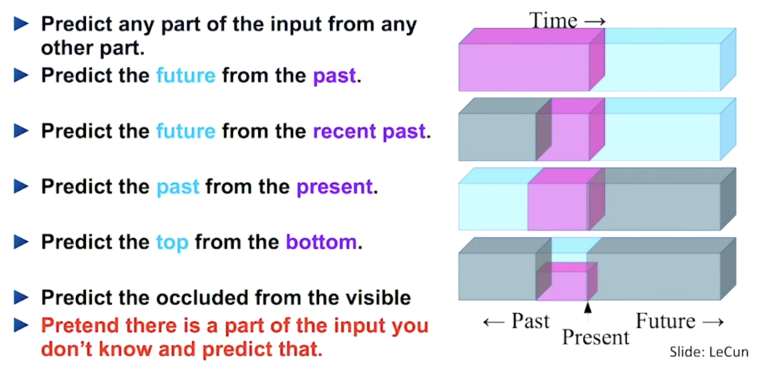

## Why self supervised learing?

* Self-supervised learning is a type of unsupervised learning. It is a way to learn useful features without human annotation.

* Data pre-processing is a time consuming and expensive process. Self-supervised learning can help us to reduce the cost of data preprocessing.



## How self supervised learing works?

write the steps here

* Step 1: Collect the data withour labels
* Step 2: Create a model
* Step 3: Train the model
* Step 4: Fine tune the model for the task we want to solve
* Step 5: Predict the model on test data
* Step 6: Evaluate the model


Self supervised learing on Brick Kilns dataset
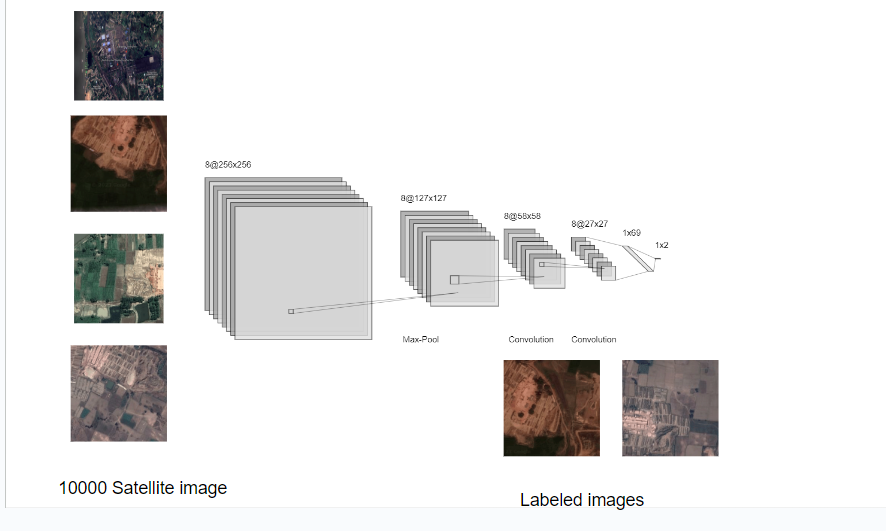